In [1]:
import torch 
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader,random_split,WeightedRandomSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter

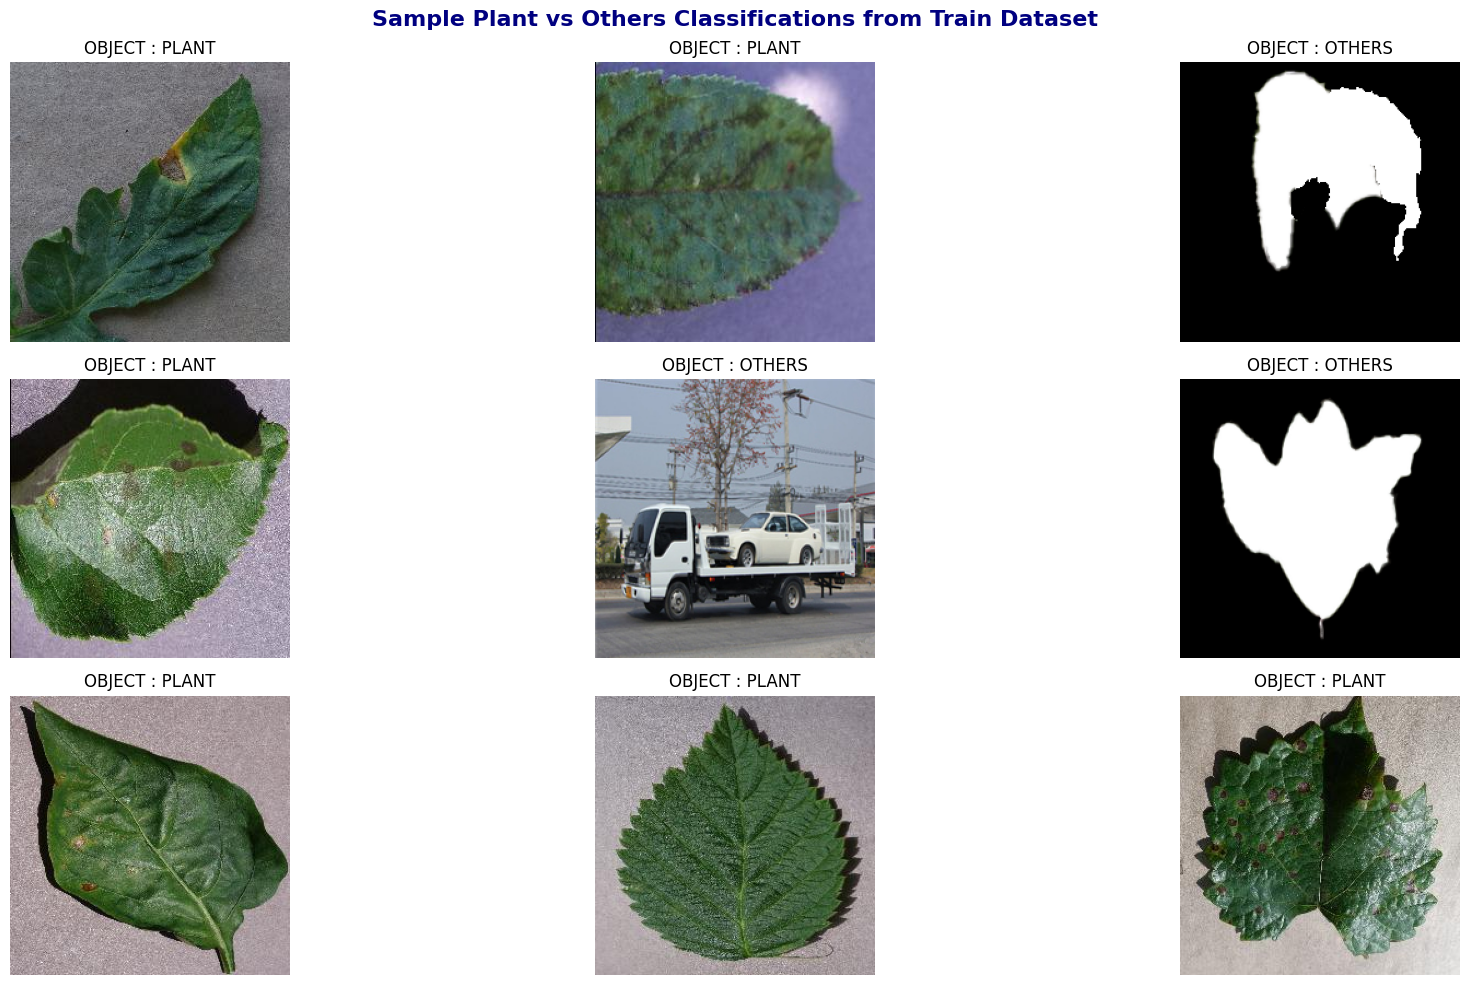

In [2]:
plotdata=datasets.ImageFolder(root=r"C:\Users\Avijit\Desktop\AgriAssure\PLANTCURE\DATASET\PLANTorSOMETHING")
classname=plotdata.classes
plt.style.use("seaborn-v0_8-muted")
plt.figure(figsize=(20,10))
rows,cols=3,3
for i in range(1,rows*cols+1):
    plt.subplot(rows,cols,i)
    randomid=torch.randint(0,len(plotdata),size=[1]).item()
    img,label=plotdata[randomid]
    plt.imshow(img)
    plt.title(f"OBJECT : {classname[label]}")
    plt.axis(False)
plt.suptitle("Sample Plant vs Others Classifications from Train Dataset", fontsize=16, fontweight='bold', color='navy')
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.98431385].


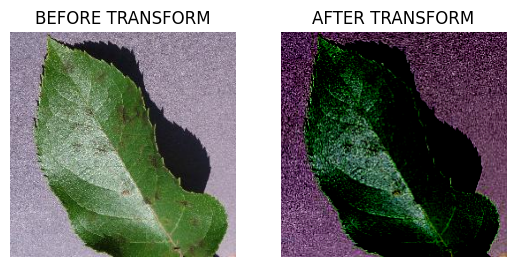

In [3]:
from pathlib import Path
from PIL import Image
import random
imagepath=Path(r"C:\Users\Avijit\Desktop\AgriAssure\PLANTCURE\DATASET\PlANTorSOMETHING")
data_transform = v2.Compose([
    v2.Resize((227, 227)),                            # Resize to AlexNet input size
    v2.ToImage(),                                     # Needed before color transforms
    v2.RandomHorizontalFlip(p=0.3),                   # Flip
    v2.ColorJitter(                                   # Randomly adjust brightness, contrast, etc.
        brightness=0.2,                               # ±20%
        contrast=0.2,
        saturation=0.2,
        hue=0.1                                       # hue ∈ [-0.1, 0.1]
    ),
    v2.RandomAutocontrast(p=0.2),                     # Random autocontrast
    v2.RandomAdjustSharpness(sharpness_factor=2, p=0.2),  # Sharpness boost
    v2.ToDtype(torch.float32, scale=True),            # Scale to [0, 1]
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])
def plot_original_transform(imagpath,transform):
    randomimglist=random.choice(list(imagepath.rglob('*.jpg')))
    image=Image.open(randomimglist).convert("RGB")
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title("BEFORE TRANSFORM")
    plt.axis(False)
    transform_img=transform(image)
    plt.subplot(1,2,2)
    plt.imshow(transform_img.permute(1,2,0))
    plt.title("AFTER TRANSFORM")
    plt.axis(False)
plot_original_transform(imagepath,data_transform)

In [4]:
from collections import Counter
import matplotlib.pyplot as plt
def check_imbalance_class(data):
    labels=[sample[1] for sample in data]
    class_count=Counter(labels)
    
    class_names = data.classes

    for i, counts in class_count.items():
     print(f"{class_names[i]}: {counts}")
     
    counts=np.array(list(class_count.values()))
    imbalance_ratio=counts.max()/counts.min()
    print(f"CLASS IMBALANCE RATION : {imbalance_ratio:.2f}")


     
    plt.figure(figsize=(20, 5))
    plt.bar([class_names[i] for i in class_count.keys()], class_count.values())
    plt.xticks(rotation=60, ha='right', fontsize=6)  # rotated + smaller font
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.tight_layout()
    plt.show()

OTHERS: 20498
PLANT: 25602
CLASS IMBALANCE RATION : 1.25


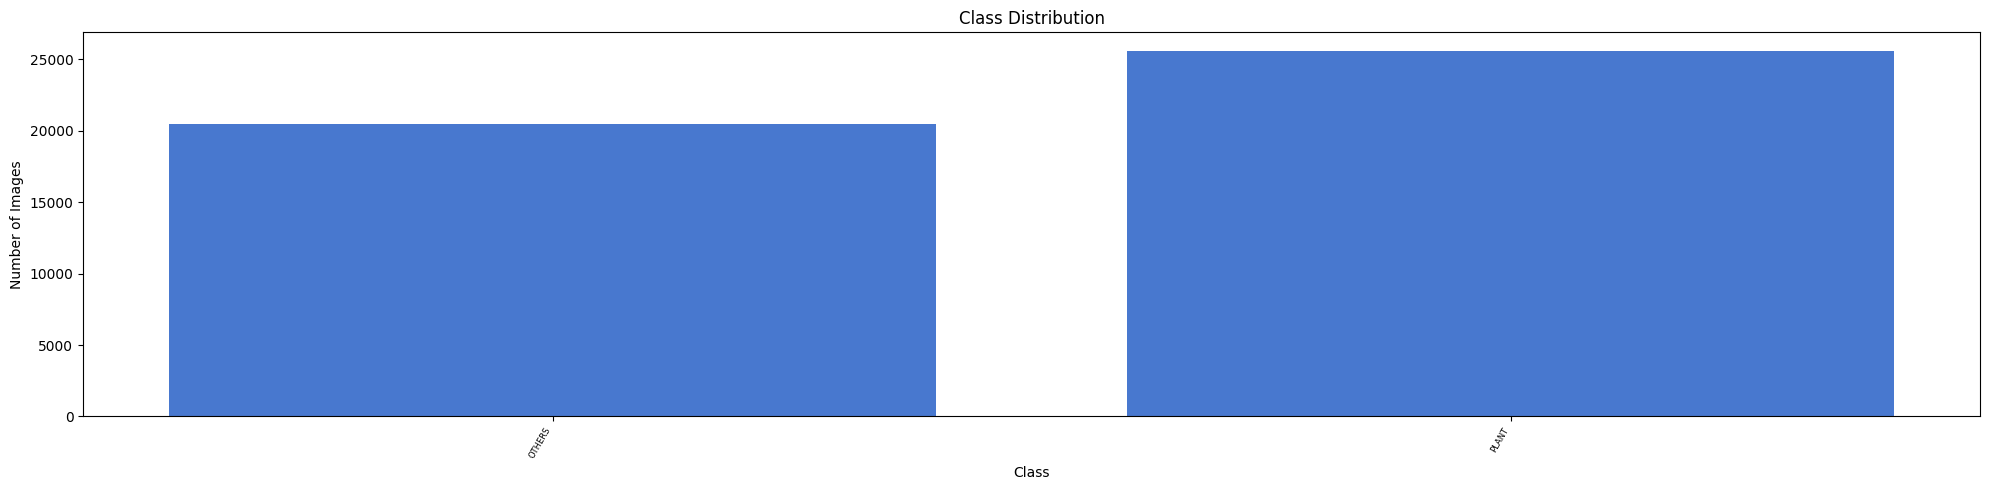

In [5]:

check_imbalance_class(plotdata)

In [6]:
import os
def getloader(root_directory, batch_size, train_ratio, image_size):
    # Transform (ImageNet normalization for pretrained models like EfficientNet)
    data_transform = v2.Compose([
        v2.Resize((image_size, image_size)),
        v2.ToImage(),
        v2.RandomHorizontalFlip(p=0.3),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load dataset
    full_dataset = datasets.ImageFolder(root=root_directory, transform=data_transform)

    # Train-test split
    train_size = int(train_ratio * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    # Calculate class weights for sampler (to handle class imbalance)
    train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
    class_counts = Counter(train_labels)
    class_weights = {label: 1.0 / count for label, count in class_counts.items()}
    sample_weights = [class_weights[label] for label in train_labels]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    # Loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler,num_workers=os.cpu_count())
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,num_workers=os.cpu_count())

    return train_loader, test_loader

In [7]:
root=r"C:\Users\Avijit\Desktop\AgriAssure\PLANTCURE\DATASET\PLANTorSOMETHING"
trainloader,testloader=getloader(root,32,0.8,224)

In [8]:
from collections import Counter
import torch

def count_class_distribution(dataloader):
    class_counts = Counter()
    for _, labels in dataloader:
        if isinstance(labels, torch.Tensor):
            labels = labels.tolist()
        class_counts.update(labels)
    return class_counts
train_class_counts = count_class_distribution(trainloader)
test_class_counts = count_class_distribution(testloader)

print("Train Class Distribution:", dict(train_class_counts))
print("Test Class Distribution:", dict(test_class_counts))


Train Class Distribution: {0: 18544, 1: 18336}
Test Class Distribution: {1: 5111, 0: 4109}


In [9]:
len(trainloader)*32+len(testloader)*32

46144

In [10]:
train_feature_batch,train_label=next(iter(trainloader))
test_feature_batch,test_label=next(iter(testloader))

In [11]:
train_feature_batch.shape

torch.Size([32, 3, 224, 224])

In [12]:
from torchvision import models

# Load pre-trained AlexNet
vgg19 = models.vgg19(weights=models.VGG19_Weights.DEFAULT)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\Avijit/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [01:01<00:00, 9.40MB/s] 


In [12]:
# Just test a batch
x, y = next(iter(trainloader))
print("Image batch shape:", x.shape)
print("Label batch shape:", y.shape)
print("Unique labels:", torch.unique(y))


Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])
Unique labels: tensor([0, 1])


In [18]:
from torchvision import models 
def get_VGG19_model(num_class, mode='no_tune'):
    model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
    
    # Replace the final layer BEFORE setting .requires_grad
    model.classifier[6] = nn.Linear(4096, num_class)

    if mode == 'no_tune':
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier[6].parameters():  # ✅ Enable only final layer
            param.requires_grad = True

    elif mode == 'partial':
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True

    elif mode == 'full':
        for param in model.parameters():
            param.requires_grad = True

    return model


In [19]:
def show_trainable_layers(model):
    print("🔍 Trainable layers in the model:\n")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"✅ {name}")
        else:
            print(f"❌ {name}")


In [20]:
classname=plotdata.classes
classname

['OTHERS', 'PLANT']

In [21]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

from torchinfo import summary
device='cuda' if torch.cuda.is_available() else 'cpu'
# model=CNN1(input=3,hidden_units=128,output=len(data.classes)).to(device)
model=get_VGG19_model(num_class=1,mode='no_tune')
model=model.to(device)
torch.cuda.empty_cache()

In [22]:
show_trainable_layers(model)

🔍 Trainable layers in the model:

❌ features.0.weight
❌ features.0.bias
❌ features.2.weight
❌ features.2.bias
❌ features.5.weight
❌ features.5.bias
❌ features.7.weight
❌ features.7.bias
❌ features.10.weight
❌ features.10.bias
❌ features.12.weight
❌ features.12.bias
❌ features.14.weight
❌ features.14.bias
❌ features.16.weight
❌ features.16.bias
❌ features.19.weight
❌ features.19.bias
❌ features.21.weight
❌ features.21.bias
❌ features.23.weight
❌ features.23.bias
❌ features.25.weight
❌ features.25.bias
❌ features.28.weight
❌ features.28.bias
❌ features.30.weight
❌ features.30.bias
❌ features.32.weight
❌ features.32.bias
❌ features.34.weight
❌ features.34.bias
❌ classifier.0.weight
❌ classifier.0.bias
❌ classifier.3.weight
❌ classifier.3.bias
✅ classifier.6.weight
✅ classifier.6.bias


In [23]:
summary(model,input_size=(1,3,224,224))


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1]                    --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]    

In [26]:
loss=nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.0001)

In [27]:
from tqdm.auto import tqdm

In [29]:
from torch.utils.tensorboard import SummaryWriter
writer=SummaryWriter(log_dir='runs1/experiment1')

In [30]:
from sklearn.metrics import accuracy_score
import torch.nn.functional as F

def train(model, dataloader, lossfn, optimizer, device):
    model.train()
    trainloss, trainacc = 0, 0

    for batch, (x, y) in tqdm(enumerate(dataloader), total=len(dataloader), desc='Training', leave=False):
        x = x.to(device)
        y = y.float().unsqueeze(1).to(device)

        pred = model(x)
        loss = lossfn(pred, y)
        trainloss += loss.item()

        prob = torch.round(torch.sigmoid(pred))
        trainacc += accuracy_score(y.detach().view(-1).cpu().numpy(), prob.detach().view(-1).cpu().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % max(1, len(dataloader) // 5) == 0:
            tqdm.write(f"🟩 Looked at {batch * len(x)}/{len(dataloader.dataset)} | Loss: {loss.item()}")

    trainloss /= len(dataloader)
    trainacc /= len(dataloader)
    print(f"\n✅ TRAINING COMPLETE — Loss: {trainloss:.4f} | Accuracy: {trainacc:.4f}")
    return trainloss, trainacc


def test(model, dataloader, lossfn, device):
    model.eval()
    testloss, testacc = 0, 0

    with torch.inference_mode():
        for batch, (x, y) in tqdm(enumerate(dataloader), total=len(dataloader), desc='Testing', leave=False):
            x = x.to(device)
            y = y.float().unsqueeze(1).to(device)

            pred = model(x)
            loss = lossfn(pred, y)
            testloss += loss.item()

            prob = torch.round(torch.sigmoid(pred))
            testacc += accuracy_score(y.detach().view(-1).cpu().numpy(), prob.detach().view(-1).cpu().numpy())

            if batch % max(1, len(dataloader) // 5) == 0:
                tqdm.write(f"🟦 Looked at {batch * len(x)}/{len(dataloader.dataset)} | Loss: {loss.item()}")

    testloss /= len(dataloader)
    testacc /= len(dataloader)
    print(f"\n🔎 TESTING COMPLETE — Loss: {testloss:.4f} | Accuracy: {testacc:.4f}")
    return testloss, testacc


In [31]:

best_acc = 0.0             
best_model_state = None    
patience = 1
counter = 0
min_delta = 0.001         

train_loss, train_acc, test_loss, test_acc = [], [], [], []

epochs=15
for epoch in tqdm(range(epochs), desc='Training', ncols=150):
    print(f"\nEpoch --> [{epoch+1}]")
    
    trainloss, trainacc = train(model, trainloader, loss, optimizer, device)
    testloss, testacc = test(model, testloader, loss, device)
    writer.add_scalar("Loss/Train", trainloss, epoch)
    writer.add_scalar("Loss/Test", testloss, epoch)
    writer.add_scalar("Accuracy/Train", trainacc, epoch)
    writer.add_scalar("Accuracy/Test", testacc, epoch)

    train_loss.append(trainloss)
    train_acc.append(trainacc)
    test_loss.append(testloss)
    test_acc.append(testacc)

    # 🔍 Check for improvement in test accuracy
    if testacc > best_acc + min_delta:
        best_acc = testacc
        counter = 0
        best_model_state = model.state_dict()  # Save best model in memory
        print(f"✅ Best model updated at epoch {epoch+1} with test accuracy: {testacc:.4f}")
    else:
        counter += 1
        print(f"🛑 No improvement. Patience: {counter}/{patience}")

    if counter >= patience:
        print(f"\n⛔ Early stopping triggered at epoch {epoch+1}. Best accuracy: {best_acc:.4f}")
        break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\n🎯 Best model loaded with test accuracy: {best_acc:.4f}")
writer.close()
torch.cuda.empty_cache()



Training:   0%|                                                                                               …


Epoch --> [1]


Training:   0%|          | 0/1153 [00:00<?, ?it/s]

🟩 Looked at 0/36880 | Loss: 0.580659031867981
🟩 Looked at 7360/36880 | Loss: 0.06464986503124237
🟩 Looked at 14720/36880 | Loss: 0.03723233938217163
🟩 Looked at 22080/36880 | Loss: 0.05682243034243584
🟩 Looked at 29440/36880 | Loss: 0.020730160176753998
🟩 Looked at 36800/36880 | Loss: 0.02721363678574562

✅ TRAINING COMPLETE — Loss: 0.0639 | Accuracy: 0.9874


Testing:   0%|          | 0/289 [00:00<?, ?it/s]

🟦 Looked at 0/9220 | Loss: 0.010572744533419609
🟦 Looked at 1824/9220 | Loss: 0.008040403015911579
🟦 Looked at 3648/9220 | Loss: 0.007834896445274353
🟦 Looked at 5472/9220 | Loss: 0.006947070360183716
🟦 Looked at 7296/9220 | Loss: 0.015201222151517868
🟦 Looked at 9120/9220 | Loss: 0.033802613615989685

🔎 TESTING COMPLETE — Loss: 0.0184 | Accuracy: 0.9961
✅ Best model updated at epoch 1 with test accuracy: 0.9961

Epoch --> [2]


Training:   0%|          | 0/1153 [00:00<?, ?it/s]

🟩 Looked at 0/36880 | Loss: 0.025931894779205322
🟩 Looked at 7360/36880 | Loss: 0.04303811863064766
🟩 Looked at 14720/36880 | Loss: 0.006848467513918877
🟩 Looked at 22080/36880 | Loss: 0.011321322992444038
🟩 Looked at 29440/36880 | Loss: 0.004346667323261499
🟩 Looked at 36800/36880 | Loss: 0.014056758023798466

✅ TRAINING COMPLETE — Loss: 0.0134 | Accuracy: 0.9975


Testing:   0%|          | 0/289 [00:00<?, ?it/s]

🟦 Looked at 0/9220 | Loss: 0.0038833345752209425
🟦 Looked at 1824/9220 | Loss: 0.0027227241080254316
🟦 Looked at 3648/9220 | Loss: 0.008522666990756989
🟦 Looked at 5472/9220 | Loss: 0.003185735549777746
🟦 Looked at 7296/9220 | Loss: 0.0028925861697643995
🟦 Looked at 9120/9220 | Loss: 0.0023481296375393867

🔎 TESTING COMPLETE — Loss: 0.0099 | Accuracy: 0.9973
✅ Best model updated at epoch 2 with test accuracy: 0.9973

Epoch --> [3]


Training:   0%|          | 0/1153 [00:00<?, ?it/s]

🟩 Looked at 0/36880 | Loss: 0.007677139714360237
🟩 Looked at 7360/36880 | Loss: 0.0017504908610135317
🟩 Looked at 14720/36880 | Loss: 0.0062941377982497215
🟩 Looked at 22080/36880 | Loss: 0.0007603203412145376
🟩 Looked at 29440/36880 | Loss: 0.002174106892198324
🟩 Looked at 36800/36880 | Loss: 0.06184341013431549

✅ TRAINING COMPLETE — Loss: 0.0077 | Accuracy: 0.9987


Testing:   0%|          | 0/289 [00:00<?, ?it/s]

🟦 Looked at 0/9220 | Loss: 0.0013637854717671871
🟦 Looked at 1824/9220 | Loss: 0.0019422475015744567
🟦 Looked at 3648/9220 | Loss: 0.004876132123172283
🟦 Looked at 5472/9220 | Loss: 0.0005953709478490055
🟦 Looked at 7296/9220 | Loss: 0.0028085215017199516
🟦 Looked at 9120/9220 | Loss: 0.0022243144921958447

🔎 TESTING COMPLETE — Loss: 0.0072 | Accuracy: 0.9983
🛑 No improvement. Patience: 1/1

⛔ Early stopping triggered at epoch 3. Best accuracy: 0.9973

🎯 Best model loaded with test accuracy: 0.9973


In [32]:
dummy_input = torch.randn(1, 3, 227, 227).to(device)  
writer.add_graph(model, dummy_input)


In [33]:
images, labels = next(iter(trainloader))

# Log input images
img_grid = torchvision.utils.make_grid(images[:16])  # First 16 images
writer.add_image('Sample Inputs', img_grid)


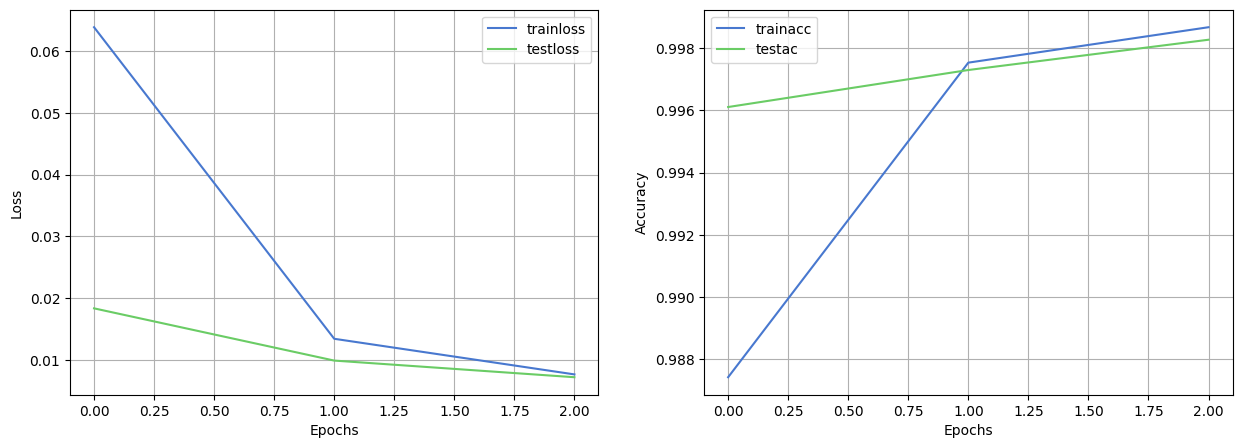

In [34]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(train_loss,)
plt.plot(test_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['trainloss','testloss'])
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(train_acc,)
plt.plot(test_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['trainacc','testac'])
plt.grid(True)
plt.show()

In [35]:
y_pred,y_true=[],[]
model.eval()
with torch.inference_mode():
    for (xsam,ysam) in (testloader):
        xsam,ysam=xsam.to(device),ysam.to(device)
        testpred=model(xsam)
        testpred=torch.sigmoid(testpred)
        testprob=torch.round(testpred)
        y_pred.extend(testprob.detach().cpu().numpy())
        y_true.extend(ysam.detach().cpu().numpy())

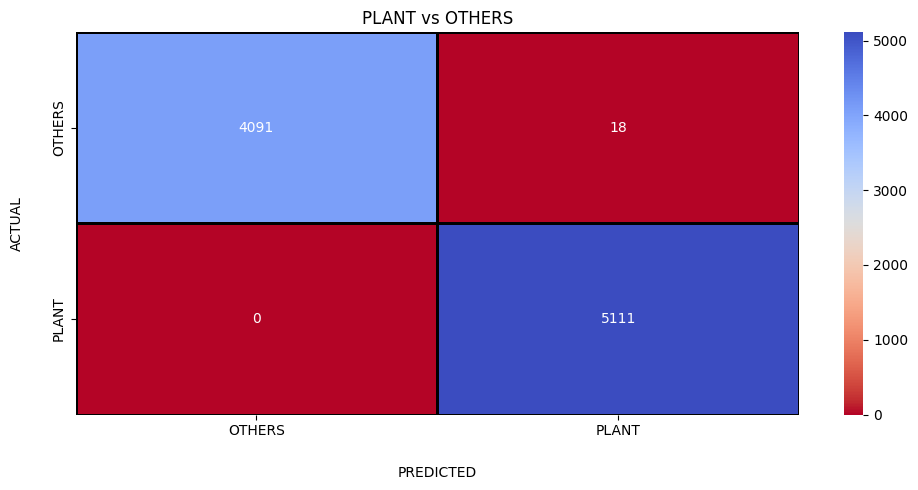

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(10,5))
sns.heatmap(cm,fmt='d',annot=True,cmap=plt.cm.coolwarm_r,xticklabels=plotdata.classes,yticklabels=plotdata.classes,linecolor='black',linewidths=2)
plt.xticks()
plt.yticks()
plt.xlabel("PREDICTED",labelpad=20)
plt.ylabel("ACTUAL",labelpad=20)
plt.title("PLANT vs OTHERS")
plt.tight_layout()
plt.show()

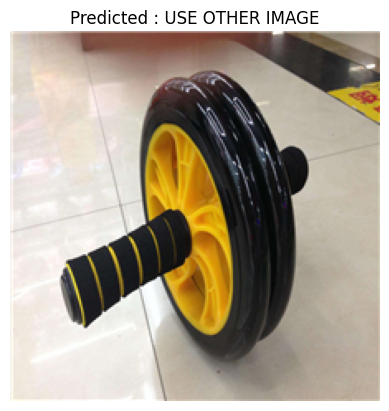

In [43]:
from PIL import Image
import torch
import torchvision.transforms.v2 as v2
import matplotlib.pyplot as plt

# Load and transform image
img_path = r"C:\Users\Avijit\Desktop\AgriAssure\PLANTCURE\DATASET\PLANTorSOMETHING\OTHERS\2.jpg"
img = Image.open(img_path).convert("RGB")

image_size = 224
data_transform = v2.Compose([
    v2.Resize((image_size, image_size)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Apply transform
transform_img = data_transform(img).unsqueeze(0).to(device)

# Make prediction
model.eval()
with torch.inference_mode():
    logit = model(transform_img)

    # Use sigmoid for binary classification
    prob = torch.sigmoid(logit)
    pred = torch.round(prob) # 0 or 1

# Class names
class_name = plotdata.classes  # Thi
pred_class = class_name[int(pred.item())]

# Show image and prediction
plt.imshow(img)
if(pred_class=='OTHERS'):
    ITEM="USE OTHER IMAGE"
plt.title(f"Predicted : {ITEM}")
plt.axis("off")
plt.show()


In [41]:
torch.save(model, r"C:\Users\Avijit\Desktop\AgriAssure\PLANTCURE\MODELS-PLANTvsOTHERS\vgg19_full_model.pth")